In [2]:
from matplotlib import pyplot as plt
from scipy.stats import chi2
import bisect
import pandas as pd
import numpy as np
import seaborn as sns
from icecream import ic
import os
import datetime

# import the data from the xlsx files
drivers_file = os.path.join('.','drivers.xlsx')
riders_file = os.path.join('.','riders.xlsx')
driver_data = pd.read_excel(drivers_file)
rider_data = pd.read_excel(riders_file)
driver_data.head()

def string_to_double_tuple(string : str)->tuple:
    return tuple(map(float, string[1:-1].split(', ')))

# data cleaning

rider_location_variables = ['pickup_location', 'dropoff_location']
rider_datetime_variables = ['request_datetime', 'pickup_datetime', 'dropoff_datetime']

for location_variable in rider_location_variables:
    rider_data[location_variable] = rider_data[location_variable].apply(string_to_double_tuple)

driver_location_variables = ['initial_location']
driver_datetime_variables = ['arrival_datetime', 'offline_datetime']

for location_variable in driver_location_variables:
    driver_data[location_variable] = driver_data[location_variable].apply(string_to_double_tuple)

# for datetime_variable in rider_datetime_variables:
#     rider_data[datetime_variable] = pd.to_datetime(rider_data[datetime_variable])
#
# for datetime_variable in driver_datetime_variables:
#     driver_data[datetime_variable] = pd.to_datetime(driver_data[datetime_variable])
driver_initial_locations = driver_data['initial_location']
rider_origins = rider_data['pickup_location']
rider_destinations = rider_data['dropoff_location']

Number of driver initial locations: 383
We reject the null hypothesis that the driver initial locations are uniformly distributed
Test statistic: 469.509138381201
Chi-squared value for 95th percentile: 101.87947396543588


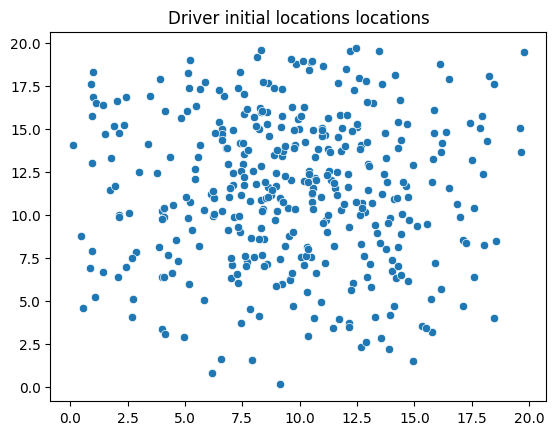

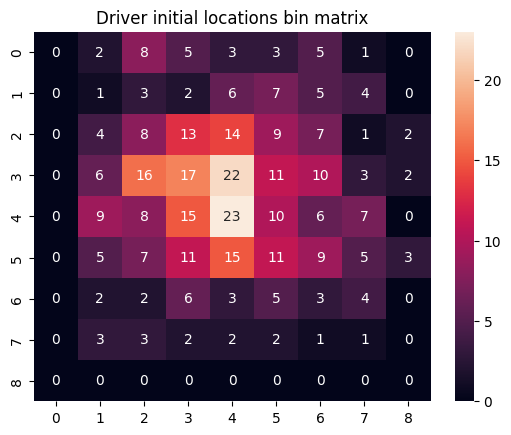

Number of rider origins: 3040
We reject the null hypothesis that the rider origins are uniformly distributed
Test statistic: 3862.960526315789
Chi-squared value for 95th percentile: 683.222435235615


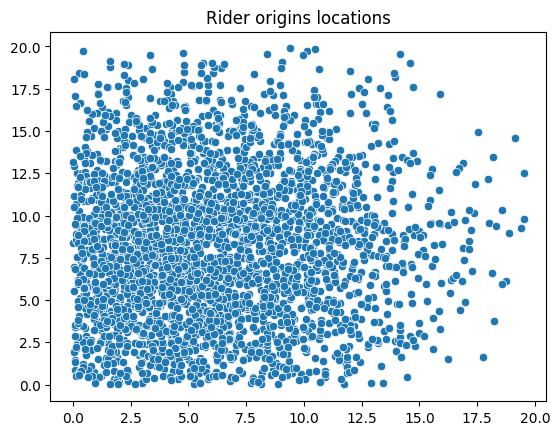

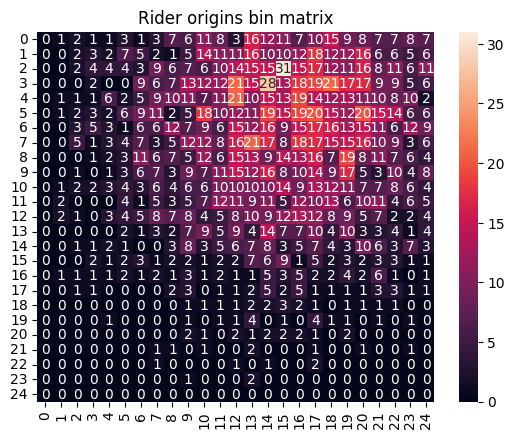

Number of rider destinations: 3040
We reject the null hypothesis that the rider destinations are uniformly distributed
Test statistic: 2221.924342105263
Chi-squared value for 95th percentile: 683.222435235615


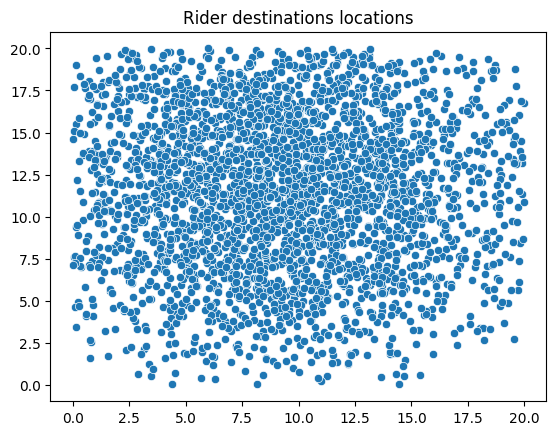

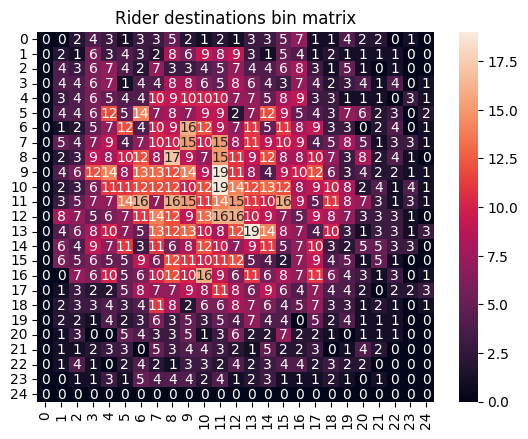

In [73]:
# Use the serial test to determine if the driver initial locations, rider origins, and rider destinations are uniformly distributed
# The serial test is a chi-squared test that tests the null hypothesis that the locations are uniformly distributed
def plot_bin_matrix(bin_matrix, title):
    sns.heatmap(bin_matrix, annot=True, fmt='g').set_title(title)

def location_plot(locations, title):
    x, y  = zip(*locations)
    if any(np.array(x) > 20) or any(np.array(y) > 20):
        raise ValueError('Coordinates must be within a 20x20 square')
    return sns.scatterplot(x=x, y=y).set_title(title)

def uniform_serial_test(locations, name : str, plots=False, expected_frequency=None):
    number_of_observations = len(locations)
    print(f'Number of {name}: {number_of_observations}')
    number_of_bins = int(np.floor(np.sqrt(number_of_observations/5)))
    bin_width = 20/number_of_bins # note hardcoding the grid size 20x20
    bin_edges = [i*bin_width for i in range(number_of_bins+1)]
    k = len(bin_edges)
    observed_bin_matrix = np.zeros((k, k)) # note hardcoding square grid
    for location in locations:
        x, y = location
        x_index = bisect.bisect_left(bin_edges, x) - 1
        y_index = bisect.bisect_left(bin_edges, y) - 1
        observed_bin_matrix[x_index][y_index] += 1
    observed_bin_matrix = np.flip(observed_bin_matrix,1) # flip the matrix so that the origin is at the bottom left
    expected_frequency = np.sum(observed_bin_matrix) / (k**2)
    chi_squared_value = np.sum((observed_bin_matrix - expected_frequency)**2) / expected_frequency
    test_statistic = chi2.ppf(0.95, df=(k**2)-1)
    if chi_squared_value > test_statistic:
        print(f'We reject the null hypothesis that the {name} are uniformly distributed')
    else:
        print(f'We fail to reject the null hypothesis that {name} are uniformly distributed')
    print(f'Test statistic: {chi_squared_value}')
    print(f'Chi-squared value for 95th percentile: {test_statistic}')
    if plots:
        # plot locations and bin matrix side by side
        location_plot(locations, f'{name} locations'.capitalize())
        plt.show()
        plot_bin_matrix(observed_bin_matrix, f'{name} bin matrix'.capitalize())
        plt.show()

show_plots = True
uniform_serial_test(driver_initial_locations, 'driver initial locations',show_plots)
uniform_serial_test(rider_origins, 'rider origins', show_plots)
uniform_serial_test(rider_destinations, 'rider destinations', show_plots)

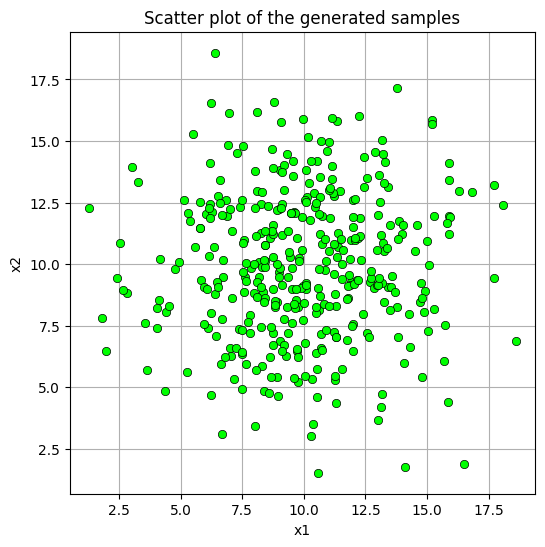

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Initialize the random seed
random_seed = 1000
np.random.seed(random_seed)  # Ensuring reproducibility

# Setting mean of the distribution (center of the 20x20 grid)
mean = np.array([10, 10])

# Adjusting covariance to keep most points within the grid
cov = np.array([[8, 0],   # Variance in x
                [0, 8]])  # Variance in y

# Creating the bivariate normal distribution
distr = multivariate_normal(mean=mean, cov=cov)

# Strict rejection sampling: Generate samples until we get exactly 383 valid points
num_samples = 383
valid_data = []

while len(valid_data) < num_samples:
    sample = distr.rvs(size=1)  # Generate one sample at a time
    if 0 <= sample[0] <= 20 and 0 <= sample[1] <= 20:
        valid_data.append(sample)

# Convert list to NumPy array
data = np.array(valid_data)

# Plotting the generated samples
plt.figure(figsize=(6,6))
plt.plot(data[:,0], data[:,1], 'o', c='lime',
        markeredgewidth=0.5,
        markeredgecolor='black')
plt.title('Scatter plot of the generated samples')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid(True)
plt.axis('equal')

plt.show()


Sample mean: [ 9.6846126  11.39786475]
Sample covariance: [[18.41976869 -0.28548022]
 [-0.28548022 18.77297999]]


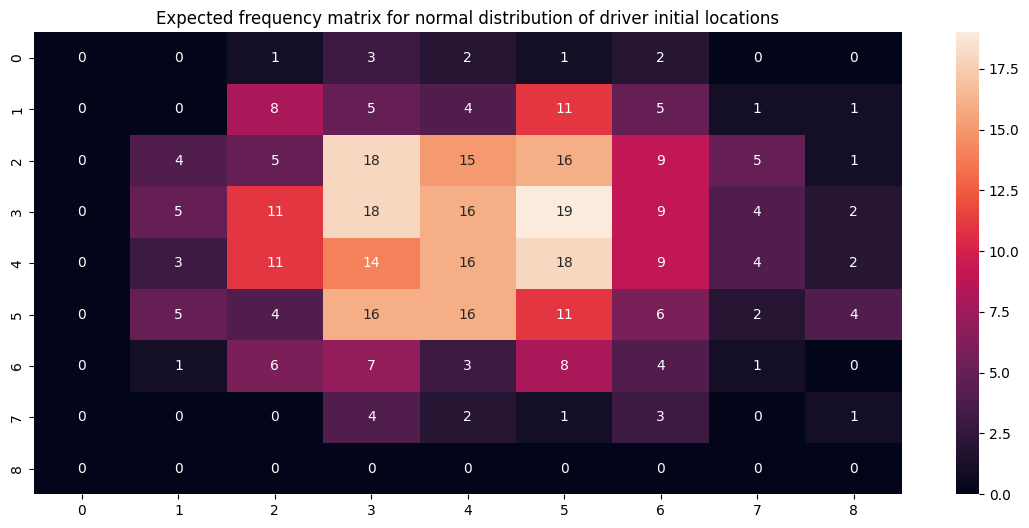

In [153]:
# create function to generate the expected frequency matrix for a normal distribution

def generate_expected_frequency_matrix(locations, num_samples, random_seed):
    np.random.seed(random_seed)
    mean = np.array([10, 10])
    x,y = zip(*locations)
    sample_mean = np.array([np.mean(x), np.mean(y)])
    cov = np.array([[9, 0],   # Variance in x
                    [0, 9]])  # Variance in y
    sample_cov = np.cov(np.array([x,y]))
    distr = multivariate_normal(mean=sample_mean, cov=sample_cov)
    print(f'Sample mean: {sample_mean}')
    print(f'Sample covariance: {sample_cov}')
    valid_data = []
    while len(valid_data) < num_samples:
        sample = distr.rvs(size=1)  # Generate one sample at a time
        if 0 <= sample[0] <= 20 and 0 <= sample[1] <= 20:
            valid_data.append(sample)
    data = np.array(valid_data)
    number_of_observations = len(locations)
    number_of_bins = int(np.floor(np.sqrt(number_of_observations/5)))
    bin_width = 20/number_of_bins
    bin_edges = [i*bin_width for i in range(number_of_bins+1)]
    k = len(bin_edges)
    expected_bin_matrix = np.zeros((k, k))
    for location in data:
        x, y = location
        x_index = bisect.bisect_left(bin_edges, x) - 1
        y_index = bisect.bisect_left(bin_edges, y) - 1
        expected_bin_matrix[x_index][y_index] += 1
    expected_bin_matrix = np.flip(expected_bin_matrix,1)
    return expected_bin_matrix

fig, ax = plt.subplots(1, 1)
plot_bin_matrix(generate_expected_frequency_matrix(driver_initial_locations, 383, 1000), 'Expected frequency matrix for normal distribution of driver initial locations')
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.float64'>
We fail to reject the null hypothesis that driver initial locations are uniformly distributed
Test statistic: nan
Chi-squared value for 95th percentile: 80.23209784876272


/var/folders/8x/12nbxrdd22904b7zs34pxyfc0000gn/T/ipykernel_740/1398871149.py:67: RuntimeWarning: divide by zero encountered in divide
  chi_squared_value = np.sum((observed_bin_matrix - expected_frequency)**2 / expected_frequency)
/var/folders/8x/12nbxrdd22904b7zs34pxyfc0000gn/T/ipykernel_740/1398871149.py:67: RuntimeWarning: invalid value encountered in divide
  chi_squared_value = np.sum((observed_bin_matrix - expected_frequency)**2 / expected_frequency)


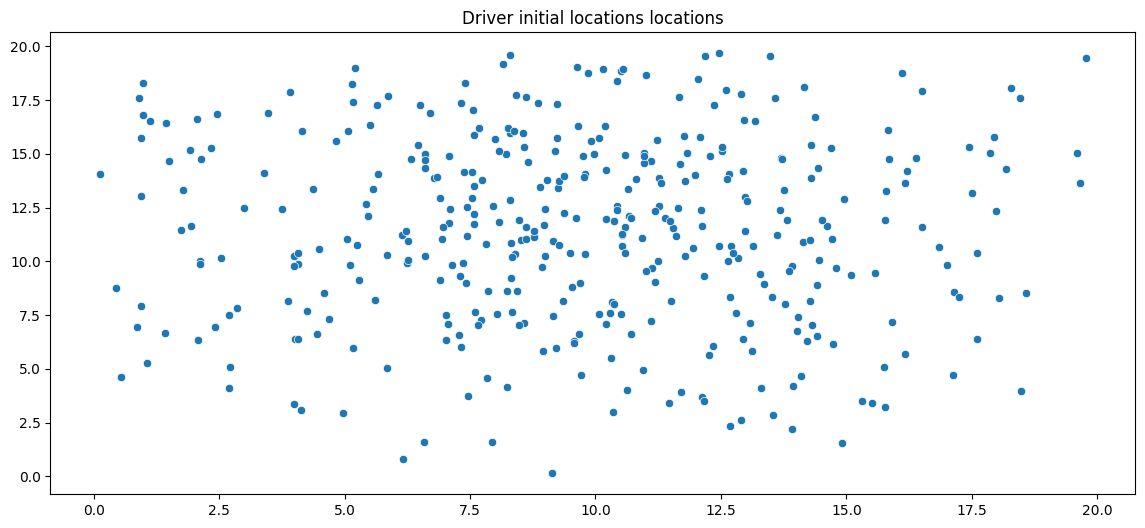

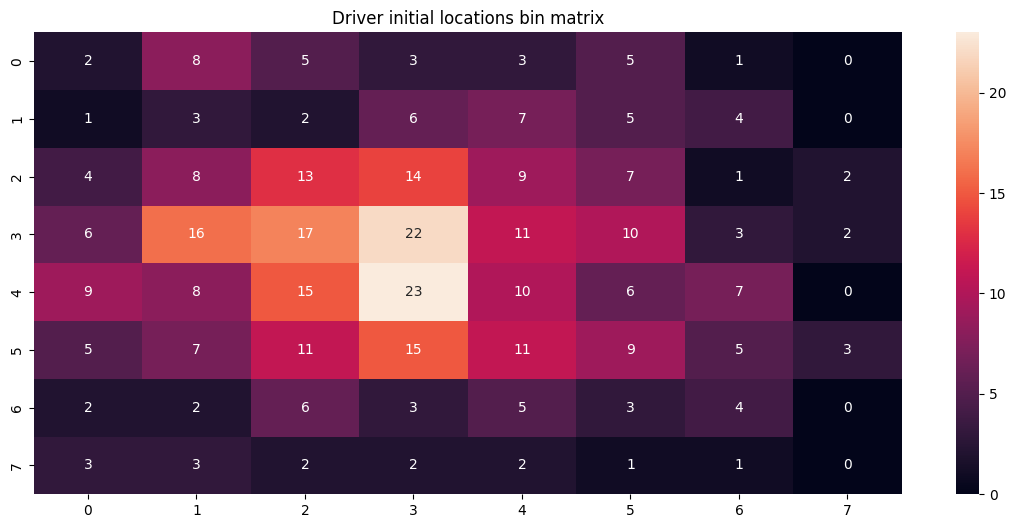

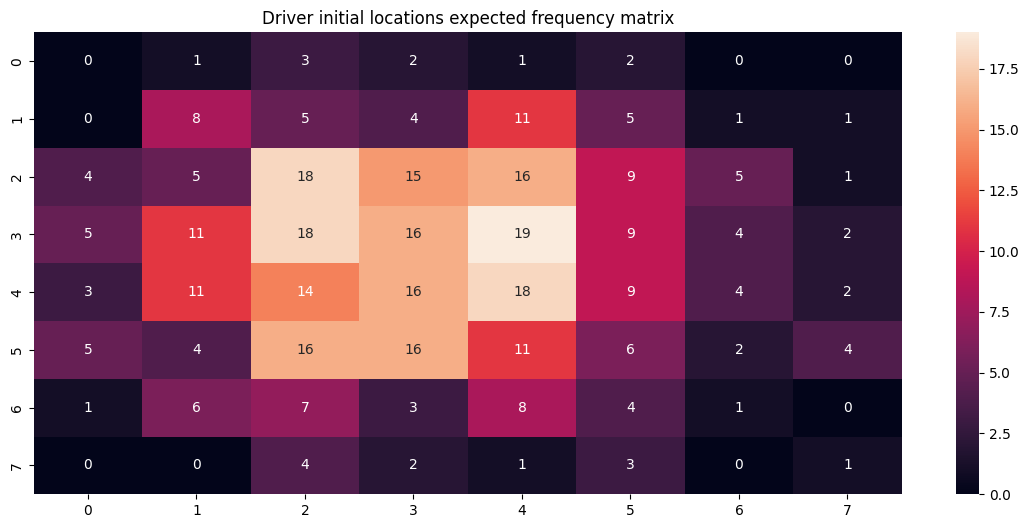

In [161]:
def normal_expected_matrix(locations, random_seed):
    number_of_observations = len(locations)
    k = int(np.floor(np.sqrt(number_of_observations/5)))
    bin_edges = [i*20/k for i in range(k+1)]

    np.random.seed(random_seed)

    x,y = zip(*locations)
    sample_mean = np.array([np.mean(x), np.mean(y)])
    sample_cov = np.cov(np.array([x,y]))

    distr = multivariate_normal(mean=sample_mean, cov=sample_cov)

    # Strict rejection sampling: Generate samples until we get exactly number_of_observations valid points
    valid_data = []
    while len(valid_data) < number_of_observations:
        sample = distr.rvs(size=1)  # Generate one sample at a time
        if 0 <= sample[0] <= 20 and 0 <= sample[1] <= 20:
            valid_data.append(sample)
    data = np.array(valid_data)

    expected_bin_matrix = np.zeros((k, k))
    for location in data:
        x, y = location
        x_index = bisect.bisect_left(bin_edges, x) - 1
        y_index = bisect.bisect_left(bin_edges, y) - 1
        expected_bin_matrix[x_index][y_index] += 1
    expected_bin_matrix = np.flip(expected_bin_matrix,1)
    
    return expected_bin_matrix

def uniform_expected_matrix(locations, random_seed):
    number_of_observations = len(locations)
    k = int(np.floor(np.sqrt(number_of_observations/5)))
    expected_frequency = number_of_observations / (k**2)
    expected_bin_matrix = np.full((k, k), expected_frequency)
    return expected_bin_matrix
    
expected_matrix : dict = {
    'uniform' : uniform_expected_matrix,
    'normal' : normal_expected_matrix
}

def get_observed_matrix(locations):
    number_of_observations = len(locations)
    k = int(np.floor(np.sqrt(number_of_observations/5)))
    bin_edges = [i*20/k for i in range(k+1)]
    observed_bin_matrix = np.zeros((k, k))
    for location in locations:
        x, y = location
        x_index = bisect.bisect_left(bin_edges, x) - 1
        y_index = bisect.bisect_left(bin_edges, y) - 1
        observed_bin_matrix[x_index][y_index] += 1
    observed_bin_matrix = np.flip(observed_bin_matrix,1)
    return observed_bin_matrix

def generalised_serial_test(locations, name : str, num_samples, random_seed, distribution : str, plots = False):
    number_of_observations = len(locations)
    k = int(np.floor(np.sqrt(number_of_observations/5)))

    expected_frequency = expected_matrix[distribution](locations, random_seed)
    df = (k**2) - 1
    if distribution == 'normal':
        df -= 2

    observed_bin_matrix = get_observed_matrix(locations)
    chi_squared_value = np.sum((observed_bin_matrix - expected_frequency)**2 / expected_frequency)
    test_statistic = chi2.ppf(0.95, df=df)
    print(f'{type(observed_bin_matrix)}')
    print(f'{type(chi_squared_value)}')
    if chi_squared_value > test_statistic:
        print(f'We reject the null hypothesis that the {name} are uniformly distributed')
    else:
        print(f'We fail to reject the null hypothesis that {name} are uniformly distributed')
    print(f'Test statistic: {chi_squared_value}')
    print(f'Chi-squared value for 95th percentile: {test_statistic}')
    if plots:
        # plot locations and bin matrix side by side
        location_plot(locations, f'{name} locations'.capitalize())
        plt.show()
        plot_bin_matrix(observed_bin_matrix, f'{name} bin matrix'.capitalize())
        plt.show()
        plot_bin_matrix(expected_frequency, f'{name} expected frequency matrix'.capitalize())
        plt.show()

generalised_serial_test(driver_initial_locations, 'driver initial locations', 383, 1000, 'normal', show_plots)



We reject the null hypothesis that the data is exponentially distributed with λ = 0.5
Test statistic: 0.9114391696347768
Critical value: 0.01984503969576501
We fail to reject the null hypothesis that the data is exponentially distributed with λ = 0.008891997794784546
Test statistic: 0.01127310332425352
Critical value: 0.01984503969576501
Estimated λ: 0.5335198676870727


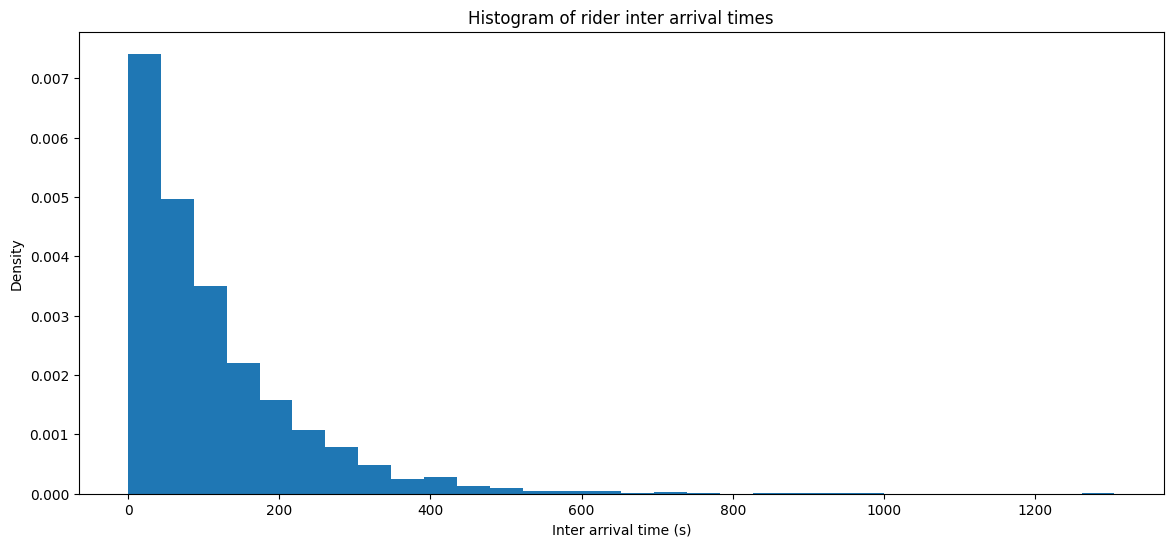

In [ ]:
# testing other variables

rider_request_times = rider_data['request_datetime']

# are rider inter arrival times exponentially distributed with λ = 30/hour?
# the exponential distribution is defined by the probability density function f(x) = λe^(-λx) for x >= 0 and 0 otherwise

# using a kstest to test the null hypothesis that the inter arrival times are exponentially distributed with λ = 30/hour
from scipy.stats import kstest

def exponential_cdf(x, λ):
    '''
    The cumulative distribution function of the exponential distribution with parameter λ/hour
    '''
    return 1 - np.exp(-λ*x)

def exponential_test(data, λ, alpha):
    data = np.sort(data)
    n = len(data)
    D_minus = np.max([i/n - exponential_cdf(data[i], λ) for i in range(n)])
    D_plus = np.max([exponential_cdf(data[i], λ) - (i-1)/n for i in range(n)])
    D = np.max([D_minus, D_plus])
    c_alpha = 1.094 
    if D > c_alpha/np.sqrt(n):
        print(f'We reject the null hypothesis that the data is exponentially distributed with λ = {λ}')
    else:
        print(f'We fail to reject the null hypothesis that the data is exponentially distributed with λ = {λ}')
    print(f'Test statistic: {D}')
    print(f'Critical value: {c_alpha/np.sqrt(n)}')

λ = 30 / 60 # convert to seconds
alpha = 0.05
rider_inter_arrival_times = rider_request_times.diff().dropna().dt.total_seconds().values


exponential_test(rider_inter_arrival_times, λ, alpha)

sample_mean = np.mean(rider_inter_arrival_times)
lambda_hat = 1/sample_mean
exponential_test(rider_inter_arrival_times, lambda_hat, alpha)
print(f'Estimated λ: {lambda_hat*60}')

# plot the histogram of the inter arrihval times
plt.hist(rider_inter_arrival_times, bins=30, density=True)
plt.title('Histogram of rider inter arrival times')
plt.xlabel('Inter arrival time (s)')
plt.ylabel('Density')
plt.show()

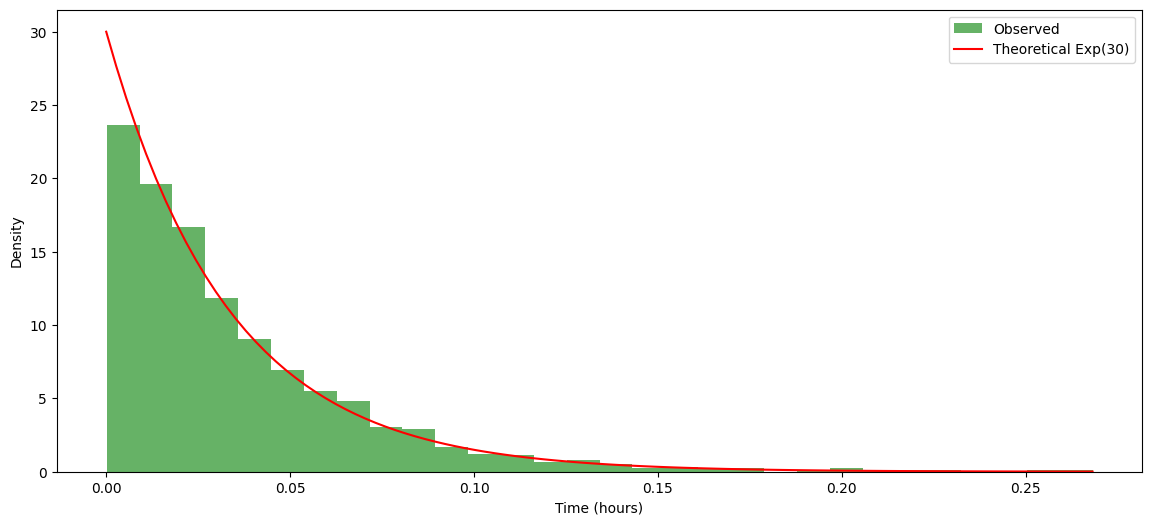

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Example time data (replace with your actual data)
data = np.random.exponential(scale=1/30, size=1000)  # Simulated example data

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Observed")

# Theoretical exponential PDF
x = np.linspace(0, max(data), 100)
plt.plot(x, 30 * np.exp(-30 * x), 'r-', label="Theoretical Exp(30)")

plt.xlabel("Time (hours)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
#TODO: Establish a method for testing inter-arrival times for riders and drivers. They are both said to be exponentially distributed with λ = 30/hour for riders and λ = 3/hour for drivers. Test the null hypothesis that the inter-arrival times are exponentially distributed with the given λ values.

#TODO: Establish a methods to test the null hypothesis that the driver working times are uniformly distributed between 5 and 8 hours. 

#TODO: Perform analysis on the location variables to see if we can determine the distribution of each the location variables. 

# Inter-arrival time hypothesis test

We reject the null hypothesis that the inter arrival times are exponentially distributed with rate = 30


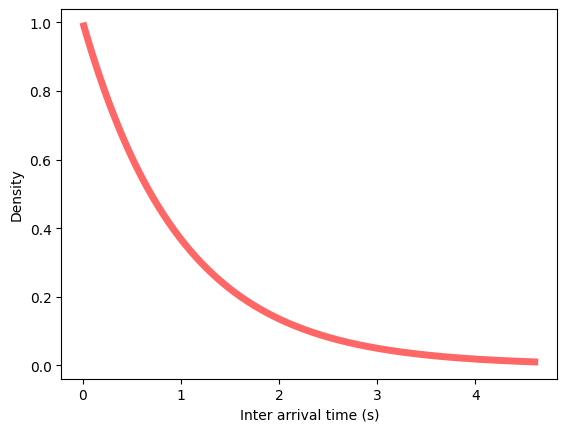

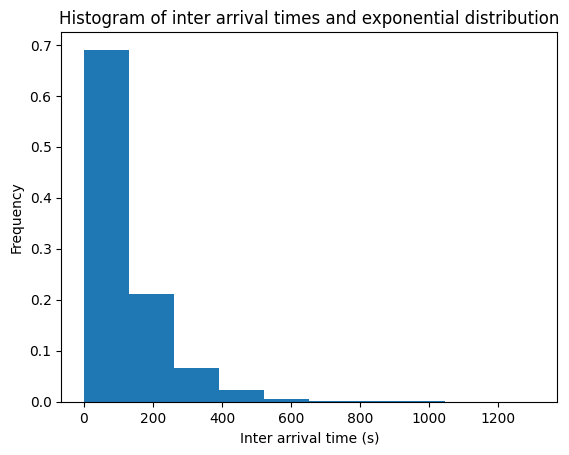

sum(inter_arrival_times)=np.float64(341767.96599999996)
We reject the null hypothesis that the inter arrival times are exponentially distributed with rate = 3
sum(inter_arrival_times)=np.float64(336149.11900000006)


In [29]:
from scipy.stats import expon
from scipy.stats import kstest

def get_inter_arrival_times(data, time_variable):
    '''
    Given a dataframe and a time variable column, returns the inter arrival times
    '''
    time_data = data[time_variable]
    inter_arrival_times = time_data.diff().dropna().dt.total_seconds().values
    return inter_arrival_times

def exponential_kstest(inter_arrival_times, rate, alpha, plot=False):
    '''
    Given some inter arrival times, a rate value, and a significance level, tests the null hypothesis that the inter arrival times are exponentially distributed with the given rate parameter. Where rate is given as the number of arrivals per hour and inter arrival times are given in seconds.
    '''
    rate_in_seconds = rate / 3600
    result = kstest(inter_arrival_times, 'expon', args=(0, 1/rate_in_seconds))
    if result.pvalue < alpha:
        print(f'We reject the null hypothesis that the inter arrival times are exponentially distributed with rate = {rate}')
    else:
        print(f'We fail to reject the null hypothesis that the inter arrival times are exponentially distributed with rate = {rate}')
    if plot:
        fig, ax = plt.subplots(1, 1)  
        x = np.linspace(expon.ppf(0.01),
                expon.ppf(0.99), 1000)
        ax.plot(x, expon.pdf(x),'r-', lw=5, alpha=0.6, label='expon pdf')
        plt.xlabel('Inter arrival time (s)')
        plt.ylabel('Density')
        plt.show()


        # distribution = expon(scale=1/rate_in_seconds) 
        # samples = distribution.rvs(size=len(inter_arrival_times))
        # plt.hist(inter_arrival_times, bins=30, density=True, alpha=0.6, color='g', label="Observed")
        # plt.hist(samples, bins=30, density=True, alpha=0.6, color='r', label="Expected")
        # # plot the pdf of the exponential distribution 
        # pdf = distribution.pdf()
        

        # plt.xlabel('Inter arrival time (s)')
        # plt.ylabel('Density')
        # plt.legend()
        # plt.show()

        # plot the histogram of the inter arrival times along with the exponential distribution
        counts, bins = np.histogram(inter_arrival_times)
        plt.hist(bins[:-1], bins, weights=counts/sum(counts))
        plt.title('Histogram of inter arrival times and exponential distribution')
        plt.ylabel('Frequency')
        plt.xlabel('Inter arrival time (s)')
        plt.show()
    print(f'{sum(inter_arrival_times)=}')


rider_inter_arrival_times = get_inter_arrival_times(rider_data, 'request_datetime')
exponential_kstest(rider_inter_arrival_times, 30, 0.05, True)

rider_inter_arrival_times = get_inter_arrival_times(driver_data, 'arrival_datetime')
exponential_kstest(rider_inter_arrival_times, 3, 0.05)

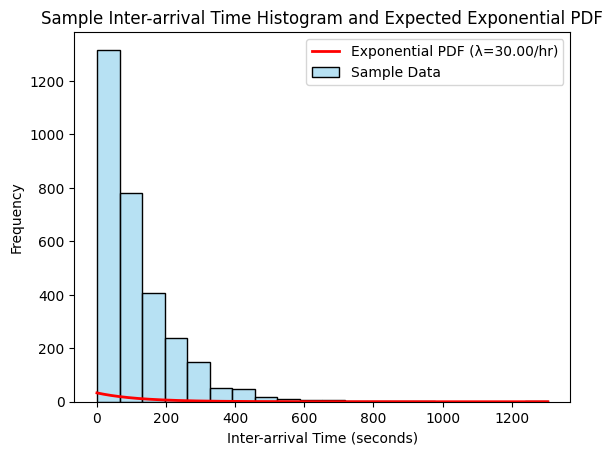

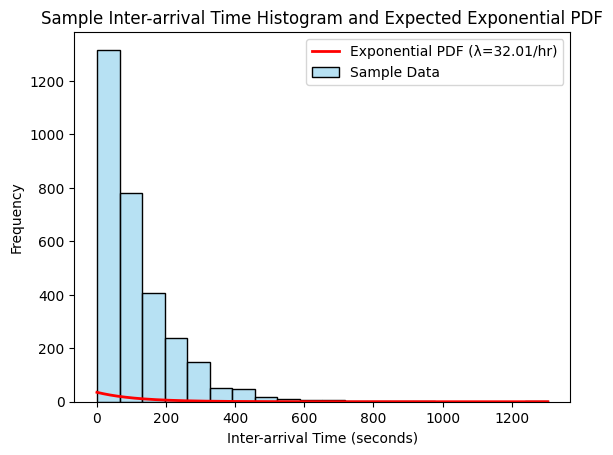

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon

def plot_interarrival_histogram(sample_times, rate_per_hour, data_name='Sample'):
    """
    Plots a histogram of inter-arrival times and overlays the expected exponential PDF.
    
    :param sample_times: Array of inter-arrival times (in seconds)
    :param rate_per_hour: Presumed rate parameter (arrivals per hour)
    """
    # Convert rate from per hour to per second
    rate_per_second = rate_per_hour / 3600.0
    
    # Fit an exponential distribution
    lambda_param = rate_per_second
    x = np.linspace(0, max(sample_times), 1000)
    pdf_values = expon.pdf(x, scale=1/lambda_param)
    
    # # Scale the PDF to match the histogram
    # bin_count, bin_edges = np.histogram(sample_times, bins=20, density=False)
    # scale_factor = max(bin_count) / max(pdf_values)
    # pdf_values *= scale_factor

    # Scale the PDF relative to the number of samples
    pdf_values *= len(sample_times) * (max(sample_times) / len(x))
    
    # Plot histogram
    sns.histplot(sample_times, bins=20, kde=False, color='skyblue', alpha=0.6, label='Sample Data')
    
    # Plot scaled PDF
    plt.plot(x, pdf_values, 'r-', lw=2, label=f'Exponential PDF (λ={rate_per_hour:.2f}/hr)')
    
    # Labels and legend
    plt.xlabel('Inter-arrival Time (seconds)')
    plt.ylabel('Frequency')
    plt.title(f'{data_name} Inter-arrival Time Histogram and Expected Exponential PDF')
    plt.legend()
    
    # Show plot
    plt.show()

# Example usage
# Generate synthetic data for testing
rate_per_hour = 30
np.random.seed(42)
# sample_interarrival_times = np.random.exponential(scale=3600/rate_per_hour, size=500)  # Example: λ = 5 arrivals per hour
sample_interarrival_times = get_inter_arrival_times(rider_data, 'request_datetime')
plot_interarrival_histogram(sample_interarrival_times, rate_per_hour=rate_per_hour)

# calculate the estimated rate parameter for the exponential distribution
sample_mean = np.mean(sample_interarrival_times)
estimated_rate = 1/sample_mean
plot_interarrival_histogram(sample_interarrival_times, rate_per_hour=estimated_rate*3600)


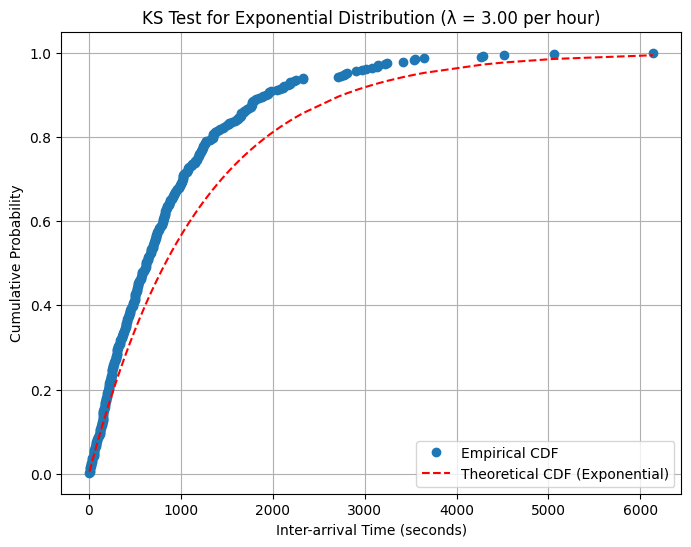

Reject the null hypothesis: Data does not follow an exponential distribution with rate 3.00 per hour.
Test statistic: 19.3979
Kolmogorov-Smirnov Test Statistic: 0.9861
P-value: 0.0000
Reject the null hypothesis: Data does not follow an exponential distribution.


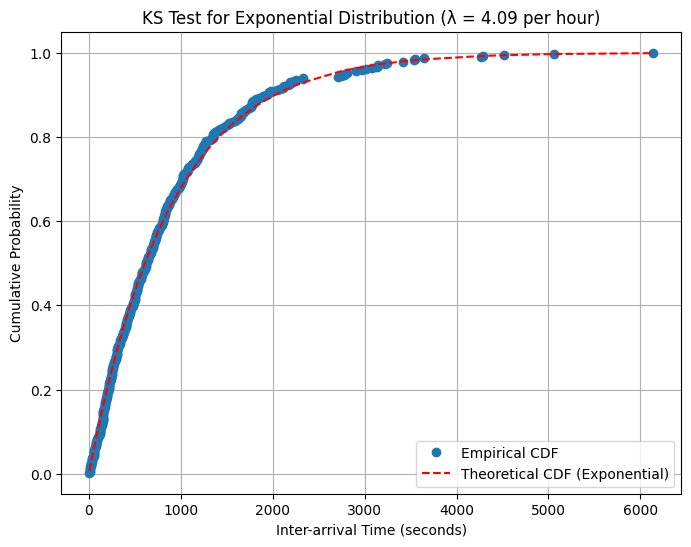

Reject the null hypothesis: Data does not follow an exponential distribution with rate 4.09 per hour.
Test statistic: 19.6458
Kolmogorov-Smirnov Test Statistic: 0.9912
P-value: 0.7671
Fail to reject the null hypothesis: Data follows an exponential distribution.


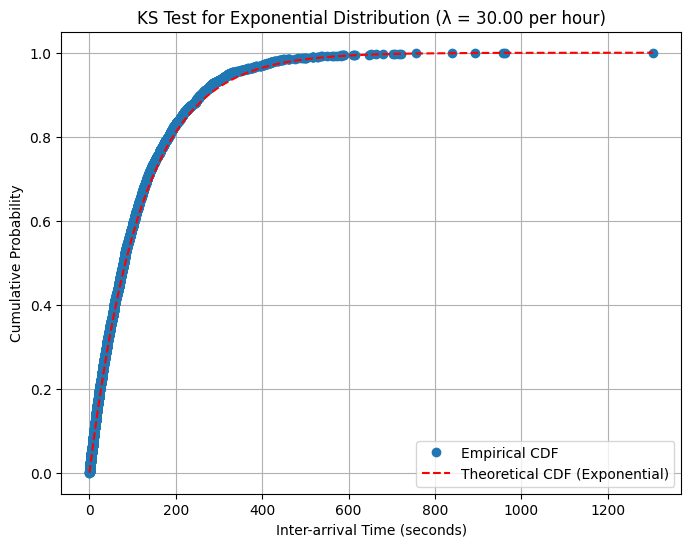

Reject the null hypothesis: Data does not follow an exponential distribution with rate 30.00 per hour.
Test statistic: 54.8669
Kolmogorov-Smirnov Test Statistic: 0.9931
P-value: 0.0078
Reject the null hypothesis: Data does not follow an exponential distribution.


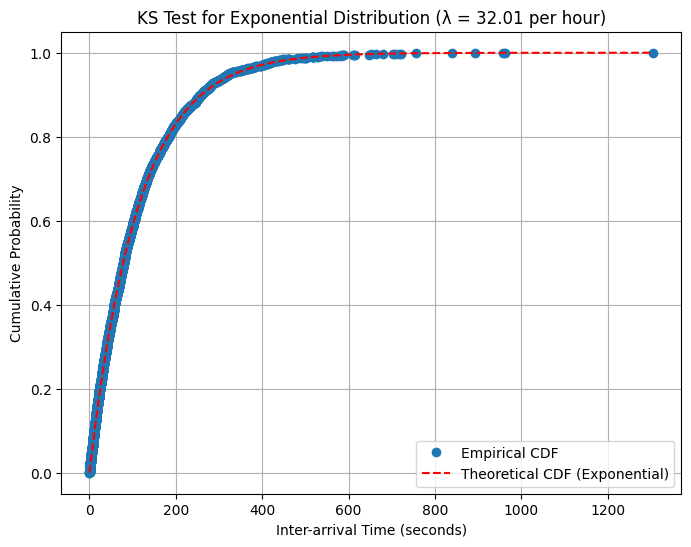

Reject the null hypothesis: Data does not follow an exponential distribution with rate 32.01 per hour.
Test statistic: 55.0068
Kolmogorov-Smirnov Test Statistic: 0.9930
P-value: 0.8558
Fail to reject the null hypothesis: Data follows an exponential distribution.


In [82]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def ks_test_exponential(inter_arrival_times, rate_per_hour, case = 'All parameters known', alpha = 0.05):
    """
    Perform a Kolmogorov-Smirnov test to check if the inter-arrival times
    follow an exponential distribution with the given rate parameter.
    
    Parameters:
    inter_arrival_times (array-like): List or array of inter-arrival times (in seconds).
    rate_per_hour (float): Rate parameter (arrivals per hour).
    
    Returns:
    None (displays a plot and prints KS test results)
    """
    # Convert rate from per hour to per second
    rate_per_second = rate_per_hour / 3600  
    
    # Perform KS test against the exponential CDF
    D, p_value = stats.kstest(inter_arrival_times, cdf='expon', args=(0, 1 / rate_per_second))
    

    # select a confidence level
    alpha = 0.05

    # # Sort data in ascending order
    # inter_arrival_times = np.sort(inter_arrival_times)

    # Compute D+ and D- statistics
    n = len(inter_arrival_times)
    D_plus = np.arange(1, n + 1) / n - stats.expon.cdf(inter_arrival_times, scale=1 / rate_per_second)
    D_minus = stats.expon.cdf(inter_arrival_times, scale=1 / rate_per_second) - np.arange(0, n) / n
    D = np.max([np.max(D_plus), np.max(D_minus)])

    # Dictionary for test cases
    cases = {
        'All parameters known': {'Test Statistic': ((np.sqrt(n) + 0.12 + 0.11 / np.sqrt(n)) * D), 'Critical Value': {0.1 : 1.224, 0.05 : 1.358, 0.025 : 1.480}},
        'Normal': {'Test Statistic': ((np.sqrt(n) + 0.12 + 0.11 / np.sqrt(n)) * D), 'Critical Value': {0.1 : 0.819, 0.05 : 0.895, 0.025 : 0.955}},
        'Exponential': {'Test Statistic': ((np.sqrt(n) + 0.26 + 0.50 / np.sqrt(n)) * (D-0.2/n)), 'Critical Value': {0.1 : 0.99, 0.05 : 1.094, 0.025 : 1.190}}
    }

    # Compute the test statistic critical value
    c_alpha = cases[case]['Critical Value'][alpha]
    test_statistic = cases[case]['Test Statistic']

    # Sort data for ECDF
    sorted_data = np.sort(inter_arrival_times)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Theoretical CDF for exponential distribution
    theoretical_cdf = stats.expon.cdf(sorted_data, scale=1 / rate_per_second)
    
    # Plot ECDF vs theoretical CDF
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_data, ecdf, marker='o', linestyle='none', label='Empirical CDF')
    plt.plot(sorted_data, theoretical_cdf, linestyle='--', color='red', label='Theoretical CDF (Exponential)')
    plt.xlabel('Inter-arrival Time (seconds)')
    plt.ylabel('Cumulative Probability')
    plt.title(f'KS Test for Exponential Distribution (λ = {rate_per_hour:.2f} per hour)')
    plt.legend()
    plt.grid()
    plt.show()
    
    if test_statistic > c_alpha:
        print(f"Reject the null hypothesis: Data does not follow an exponential distribution with rate {rate_per_hour:.2f} per hour.")
        print(f"Test statistic: {test_statistic:.4f}")
    else:
        print(f"Fail to reject the null hypothesis: Data follows an exponential distribution with rate {rate_per_hour:.2f} per hour.")
    
    # Print KS test results
    print(f"Kolmogorov-Smirnov Test Statistic: {D:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject the null hypothesis: Data follows an exponential distribution.")
    else:
        print("Reject the null hypothesis: Data does not follow an exponential distribution.")


driver_inter_arrival_times = get_inter_arrival_times(driver_data, 'arrival_datetime')
ks_test_exponential(driver_inter_arrival_times, 3)

driver_sample_mean = np.mean(driver_inter_arrival_times)
estimated_hourly_rate = 1/driver_sample_mean * 3600
ks_test_exponential(driver_inter_arrival_times, estimated_hourly_rate, case='Exponential')

rider_inter_arrival_times = get_inter_arrival_times(rider_data, 'request_datetime')
ks_test_exponential(rider_inter_arrival_times, 30)

sample_mean = np.mean(rider_inter_arrival_times)
estimated_hourly_rate = 1/sample_mean * 3600
ks_test_exponential(rider_inter_arrival_times, estimated_hourly_rate, case='Exponential')

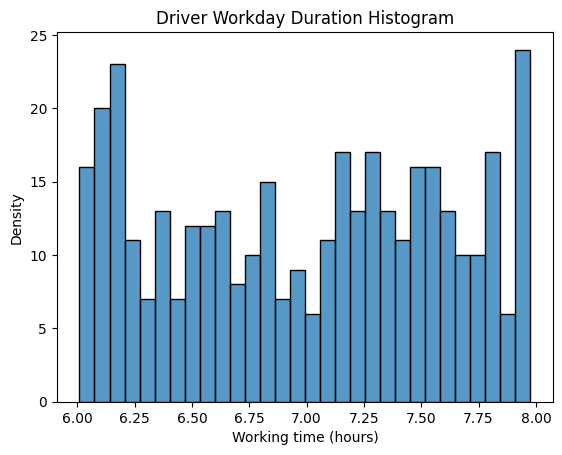

There are driver working times less than 5 hours or greater than 8 hours
min(driver_working_times)=np.float64(6.009171111111111)
max(driver_working_times)=np.float64(7.975658611111111)
observed_bin_matrix=array([ 6,  2, 14,  5,  8, 10,  8,  8,  3,  5,  3,  4,  3,  6,  4,  4,  2,
        2,  7,  4,  4,  4,  8,  8,  1,  2,  3,  6,  2,  4, 10,  5,  2,  2,
        2,  4,  4,  4,  1,  5,  4,  4,  3,  6,  8,  4,  6,  6,  4,  8,  8,
        6,  3,  2,  7,  5,  7,  6,  7,  8,  3,  4,  5,  4,  3,  7,  5,  2,
        4, 10,  5,  2,  2,  6, 13,  7])
We reject the null hypothesis that the driver working times are uniformly distributed
Test statistic: 103.75718015665795
Chi-squared value for 95th percentile: 96.21667075350383


In [ ]:
# test the driver working times
driver_working_times = driver_data['offline_datetime'] - driver_data['arrival_datetime']

# convert to hours
driver_working_times = driver_working_times.dt.total_seconds().values / 3600

# plot histogram of driver working times
sns.histplot(driver_working_times, bins=30)
plt.title('Driver Workday Duration Histogram')
plt.xlabel('Working time (hours)')
plt.ylabel('Density')
filename = 'driver_workday_duration_histogram.png'
filename = os.path.join('./Report/figures/distribution_analysis/', filename)
plt.savefig(filename)
plt.show()

# are any times less than 5 hours or greater than 8 hours?
if any(driver_working_times < 5*3600) or any(driver_working_times > 8*3600):
    print('There are driver working times less than 5 hours or greater than 8 hours')
else:
    print('There are no driver working times less than 5 hours or greater than 8 hours')

# chisq test for driver working times
number_of_observations = len(driver_working_times)
print(f'{min(driver_working_times)=}')
print(f'{max(driver_working_times)=}')
number_of_bins = int(np.floor(number_of_observations/5))
# number_of_bins = 10
expected_frequency = number_of_observations / number_of_bins
observed_bin_matrix = np.histogram(driver_working_times, bins=number_of_bins, density=False)[0]
print(f'{observed_bin_matrix=}')
chi_squared_value = np.sum((observed_bin_matrix - expected_frequency)**2 / expected_frequency)
test_statistic = chi2.ppf(0.95, df=number_of_bins-1)
if chi_squared_value > test_statistic:
    print(f'We reject the null hypothesis that the driver working times are uniformly distributed')
    print(f'Test statistic: {chi_squared_value}')
    print(f'Chi-squared value for 95th percentile: {test_statistic}')
else:
    print(f'We fail to reject the null hypothesis that the driver working times are uniformly distributed')
    print(f'Test statistic: {chi_squared_value}')
    print(f'Chi-squared value for 95th percentile: {test_statistic}')

In [106]:
# Average speed analysis of ride
rider_data['ride_duration'] = (rider_data['dropoff_datetime'] - rider_data['pickup_datetime']).dt.total_seconds() / 3600
rider_data['ride_distance'] = rider_data.apply(lambda x: np.linalg.norm(np.array(x['dropoff_location']) - np.array(x['pickup_location'])), axis=1)
rider_data['ride_speed'] = rider_data['ride_distance'] / rider_data['ride_duration']

# test the hypothesis that the average speed of a ride is 20 mph
from scipy.stats import ttest_1samp
t_statistic, p_value = ttest_1samp(rider_data['ride_speed'], 20)

if p_value < 0.05:
    print('We reject the null hypothesis that the average speed of a ride is 20 mph')
else:
    print('We fail to reject the null hypothesis that the average speed of a ride is 20 mph')
rider_data['ride_speed'].describe()

We fail to reject the null hypothesis that the average speed of a ride is 20 mph


count    2881.000000
mean       20.337028
std         2.399703
min        16.666759
25%        18.261627
50%        20.050882
75%        22.315782
max        24.991933
Name: ride_speed, dtype: float64